In [1]:
import sys
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm
import optuna
import joblib
from sklearn.metrics import accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../src')
import const
from metrics import micro_f1_similarity, row_wise_micro_averaged_f1_score

pd.options.display.max_rows = 120

In [2]:
valid_df = pd.read_csv('../data/input/train_soundscape_labels.csv')
use_idx = valid_df[~valid_df["audio_id"].isin([7019, 7954, 14473])].index
# use_idx = valid_df[valid_df["audio_id"].isin([7019, 7954, 14473, 2782, 7843, 20152, 28933, 54955])].index
drop_idx = valid_df[valid_df["audio_id"].isin([7019, 7954, 14473])].index
valid_df = valid_df.iloc[use_idx].reset_index(drop=True)

val_y_labels = valid_df["birds"].tolist()

all_diff_scores = {}

In [3]:
def fill_dropped(dropped_array, drop_idx):
    filled_array = np.zeros(
        (len(dropped_array) + len(drop_idx), dropped_array.shape[1])
    )
    idx_array = np.arange(len(filled_array))
    use_idx = np.delete(idx_array, drop_idx)
    filled_array[use_idx, :] = dropped_array
    return filled_array

In [4]:
def extract_label(preds, th=0.5):
    events = preds >= th
    nocall_col = np.zeros((len(preds), 1)).astype(bool)
    nocall_col[events.sum(1) == 0] = True
    events = np.concatenate([events, nocall_col], axis=1)
    
    predict_labels = []
    for i in range(len(events)):
        event = events[i, :]
        labels = np.argwhere(event).reshape(-1).tolist()
        
        row_labels = []
        for label in labels:
            row_labels.append(const.INV_BIRD_CODE[label])
        predict_labels.append(" ".join(row_labels))

    return predict_labels

In [5]:
def set_audio_base_score(pred_labels, df):
    score_dict = {}
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        score = row_wise_micro_averaged_f1_score(audio_df["birds"], np.array(pred_labels)[idxs])
        score_dict[audio_id] = score
        
    return score_dict

def get_audio_score(pred_labels, df, score_dict):
    diff_scores = {}

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        score = row_wise_micro_averaged_f1_score(audio_df["birds"], np.array(pred_labels)[idxs])
        base_score = score_dict[audio_id]

        print(f"{audio_id}: {score:.4f} [{score - base_score:.3f}]")
        diff_scores[audio_id] = score - base_score
        
    return diff_scores

In [170]:
oof112 = np.load("../logs/exp_112_20210520045116_0.638/oof.npy")
oof112 = fill_dropped(oof112, drop_idx)
oof114 = np.load("../logs/exp_114_20210520192947_0.650/oof.npy")
oof114 = fill_dropped(oof114, drop_idx)
oof115 = np.load("../logs/exp_115_20210520232446_0.631/oof.npy")
oof115 = fill_dropped(oof115, drop_idx)
oof116 = np.load("../logs/exp_116_20210521031557_0.641/oof.npy")
oof116 = fill_dropped(oof116, drop_idx)
oof117 = np.load("../logs/exp_117_20210521070917_0.640/oof.npy")
oof117 = fill_dropped(oof117, drop_idx)
oof118 = np.load("../logs/exp_118_20210521110036_0.653/oof.npy")
oof118 = fill_dropped(oof118, drop_idx)
oof121 = np.load("../logs/exp_121_20210521215739_0.637/oof.npy")
oof121 = fill_dropped(oof121, drop_idx)

oof129 = np.load("../logs/exp_129_20210523145254_0.641/oof.npy")
oof129 = fill_dropped(oof129, drop_idx)
oof131 = np.load("../logs/exp_131_20210524005536_0.641/oof.npy")
oof131 = fill_dropped(oof131, drop_idx)
oof132 = np.load("../logs/exp_132_20210524061303_0.623/oof.npy")
oof132 = fill_dropped(oof132, drop_idx)
oof133 = np.load("../logs/exp_133_20210524105841_0.630/oof.npy")
oof133 = fill_dropped(oof133, drop_idx)
oof134 = np.load("../logs/exp_134_20210524160839_0.636/oof.npy")
oof134 = fill_dropped(oof134, drop_idx)
oof135 = np.load("../logs/exp_135_20210524214504_0.649/oof.npy")
oof135 = fill_dropped(oof135, drop_idx)
oof136 = np.load("../logs/exp_136_20210525032138_0.623/oof.npy")
oof136 = fill_dropped(oof136, drop_idx)
oof137 = np.load("../logs/exp_137_20210525173848_0.631/oof.npy")
oof137 = fill_dropped(oof137, drop_idx)
oof139 = np.load("../logs/exp_139_20210526031224_0.661/oof.npy")
oof139 = fill_dropped(oof139, drop_idx)
oof140 = np.load("../logs/exp_140_20210525120925_0.577/oof.npy")
oof140 = fill_dropped(oof140, drop_idx)
oof142 = np.load("../logs/exp_142_20210526125837_0.651/oof.npy")
oof142 = fill_dropped(oof142, drop_idx)
oof143 = np.load("../logs/exp_143_20210526174719_0.642/oof.npy")
oof143 = fill_dropped(oof143, drop_idx)
oof144 = np.load("../logs/exp_144_20210526221306_0.654/oof.npy")
oof144 = fill_dropped(oof144, drop_idx)
oof145 = np.load("../logs/exp_145_20210527081010_0.640/oof.npy")
oof145 = fill_dropped(oof145, drop_idx)
oof156 = np.load("../logs/exp_156_20210528092304_0.643/oof.npy")
oof156 = fill_dropped(oof156, drop_idx)

oof144 = np.load("../logs/exp_144_20210526221306_0.654/oof.npy")
oof144 = fill_dropped(oof144, drop_idx)
oof146 = np.load("../logs/exp_146_20210527110713_0.637/oof.npy")
oof146 = fill_dropped(oof146, drop_idx)
oof149 = np.load("../logs/exp_149_20210527160401_0.633/oof.npy")
oof149 = fill_dropped(oof149, drop_idx)
oof150 = np.load("../logs/exp_150_20210527195843_0.640/oof.npy")
oof150 = fill_dropped(oof150, drop_idx)
oof151 = np.load("../logs/exp_151_20210527195745_0.645/oof.npy")
oof151 = fill_dropped(oof151, drop_idx)
oof152 = np.load("../logs/exp_152_20210527200140_0.625/oof.npy")
oof152 = fill_dropped(oof152, drop_idx)
oof153 = np.load("../logs/exp_153_20210527200336_0.643/oof.npy")
oof153 = fill_dropped(oof153, drop_idx)
oof154 = np.load("../logs/exp_154_20210528013208_0.635/oof.npy")
oof154 = fill_dropped(oof154, drop_idx)
oof155 = np.load("../logs/exp_155_20210528053901_0.638/oof.npy")
oof155 = fill_dropped(oof155, drop_idx)
oof156 = np.load("../logs/exp_156_20210528092304_0.643/oof.npy")
oof156 = fill_dropped(oof156, drop_idx)
oof157 = np.load("../logs/exp_157_20210528131517_0.645/oof.npy")
oof157 = fill_dropped(oof157, drop_idx)
oof158 = np.load("../logs/exp_158_20210528172326_0.633/oof.npy")
oof158 = fill_dropped(oof158, drop_idx)
oof159 = np.load("../logs/exp_159_20210528075925_0.639/oof.npy")
oof159 = fill_dropped(oof159, drop_idx)
oof160 = np.load("../logs/exp_160_20210528080013_0.628/oof.npy")
oof160 = fill_dropped(oof160, drop_idx)
oof161 = np.load("../logs/exp_161_20210528080055_0.638/oof.npy")
oof161 = fill_dropped(oof161, drop_idx)



# nocall classification
oof59 = np.load("../logs/exp_059_20210505100513_0.666/oof.npy")
oof70 = np.load("../logs/exp_070_20210508193023_0.882/oof.npy")
oof79 = np.load("../logs/exp_079_20210511132329_0.874/oof.npy")
oof83 = np.load("../logs/exp_083_20210512081958_0.827/oof.npy")
oof99 = np.load("../logs/exp_099_20210515202257_0.859/oof.npy")

In [7]:
# oof_list = [
#     oof112,
#     oof114,
#     oof115,
#     oof116,
#     oof117,
#     oof118,

#     oof129,
#     oof131,
#     oof132,
#     oof139,
# ]

oof_list = [
    oof144,
    oof146,
    oof149,
    oof150,
    oof151,
    oof152,
    oof153,
    oof154,
    oof155,
    oof156,
    oof157,
    oof158,
]

concat_oof = []
for oof_ in oof_list:
    concat_oof.append(oof_[np.newaxis, :, :])
concat_oof = np.concatenate(concat_oof)

## BaseScore

In [8]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]
base_oof_labels = extract_label(oof, th=0.33)
score_dict = set_audio_base_score(base_oof_labels, valid_df)
np.mean(list(score_dict.values()))

0.692598039215686

## All nocall

In [9]:
oof_labels = ["nocall"] * len(valid_df)
score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
score

0.5769607843137236

## Simple Average

In [10]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]


th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [11]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7017 (th=0.26)

best score: 0.6981 (th=0.27)


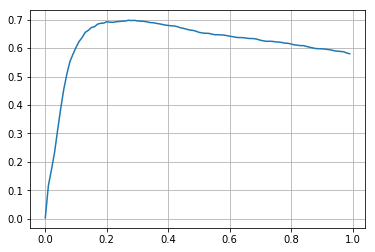

In [12]:
plt.plot(th_list, scores)
plt.grid()

In [13]:
best_labels1 = best_final_labels
diff_scores0 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["avg"] = diff_scores0

2782: 0.3164 [0.071]
7843: 0.9750 [0.000]
10534: 0.6500 [-0.019]
11254: 0.8917 [-0.008]
18003: 0.5528 [0.056]
20152: 0.9500 [0.000]
21767: 0.2792 [0.038]
26709: 0.5361 [0.000]
26746: 0.7028 [0.008]
28933: 0.4667 [0.004]
31928: 0.9917 [0.000]
42907: 0.7250 [-0.008]
44957: 0.7278 [0.008]
50878: 0.8333 [-0.033]
51010: 0.5028 [0.019]
54955: 0.8667 [-0.008]
57610: 0.9000 [-0.033]


## Simple Average + nocall classification

In [14]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [15]:
birdcall_p = oof99

for idx in range(len(oof)):
    bp = birdcall_p[idx]
    if bp <= 0.3:
        col1_idx = np.argsort(oof[idx, :])[-1:]
        oof[idx, col1_idx] /= 5

In [16]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(300):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [17]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score:0.7027 (th=0.26)

best score: 0.6991 (th=0.27)


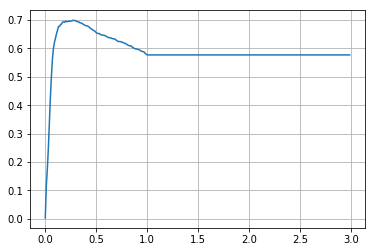

In [18]:
plt.plot(th_list, scores)
plt.grid()

In [19]:
best_labels_nc = best_final_labels
diff_scores1 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["avg_nc"] = diff_scores1

2782: 0.3164 [0.071]
7843: 0.9750 [0.000]
10534: 0.6500 [-0.019]
11254: 0.8917 [-0.008]
18003: 0.5528 [0.056]
20152: 0.9583 [0.008]
21767: 0.2792 [0.038]
26709: 0.5361 [0.000]
26746: 0.7028 [0.008]
28933: 0.4667 [0.004]
31928: 0.9917 [0.000]
42907: 0.7250 [-0.008]
44957: 0.7278 [0.008]
50878: 0.8333 [-0.033]
51010: 0.5028 [0.019]
54955: 0.8750 [0.000]
57610: 0.9000 [-0.033]


## Voting

In [20]:
def voting(oof_labels_list, vote_lim):
    final_oof_labels = []
    
    for idx in range(len(oof_labels_list[0])):
        birds = []

        for labels in oof_labels_list:
            birds.extend(labels[idx].split(" "))

        birds = [x for x in birds if "nocall" != x and "" != x]
        count_birds = Counter(birds)

        final_birds = []
        for key, value in count_birds.items():
            if value >= vote_lim:
                final_birds.append(key)

        if len(final_birds) == 0:
            final_birds.append("nocall")

        final_oof_labels.append(" ".join(final_birds))

    return final_oof_labels

In [21]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_vote_lim = 0
best_final_labels = None

# for vote_lim in range(1, len(oof_labels_list)):
for vote_lim in [1, 2, 3]:
    for i in tqdm(range(100)):
        th = i / 100.0
        
        oof_labels_list = []
        for oof_ in oof_list:
            oof_labels_ = extract_label(oof_[use_idx, :], th)
            oof_labels_list.append(oof_labels_)

        final_oof_labels = voting(oof_labels_list, vote_lim)

        score = row_wise_micro_averaged_f1_score(val_y_labels, final_oof_labels)
            
        if best_score < score:
            best_score = score
            best_th = th
            best_vote_lim = vote_lim
            best_final_labels = final_oof_labels
                
        th_list.append(th)
        scores.append(score)

In [22]:
best_score   # 0.7430

0.6945915032679715

In [23]:
best_th

0.44

In [24]:
best_vote_lim

3

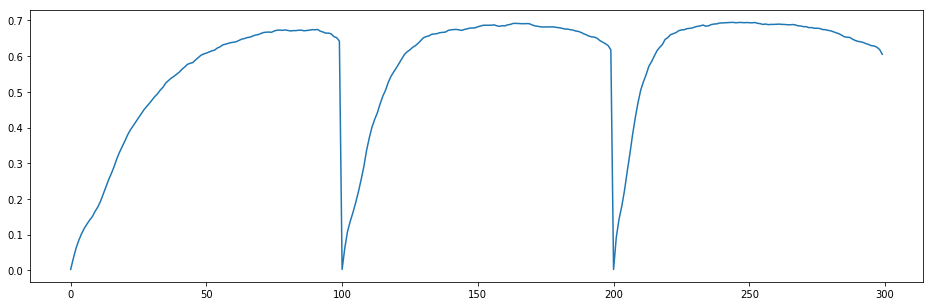

In [25]:
plt.figure(figsize=(16, 5))
plt.plot(scores)

In [26]:
diff_scores2 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["voting"] = diff_scores2

2782: 0.3275 [0.083]
7843: 0.9750 [0.000]
10534: 0.6583 [-0.011]
11254: 0.8806 [-0.019]
18003: 0.5361 [0.039]
20152: 0.9417 [-0.008]
21767: 0.2681 [0.026]
26709: 0.5444 [0.008]
26746: 0.6833 [-0.011]
28933: 0.4667 [0.004]
31928: 0.9917 [0.000]
42907: 0.7583 [0.025]
44957: 0.7167 [-0.003]
50878: 0.8000 [-0.067]
51010: 0.4903 [0.007]
54955: 0.8667 [-0.008]
57610: 0.9028 [-0.031]


## Simple Average > PostProcess_v12

In [27]:
def post_process_site_12(preds, threshold=0.5, maxpreds=3):
    preds = preds * (preds >= threshold)   # remove preds < threshold
    
#     next_preds = np.concatenate([preds[1:], preds[-1:]])  # pred corresponding to next window
#     prev_preds = np.concatenate([preds[:1], preds[:-1]])  # pred corresponding to previous window

    next_preds = np.concatenate([preds[1:], np.zeros((1, preds.shape[-1]))])  # pred corresponding to next window
    prev_preds = np.concatenate([np.zeros((1, preds.shape[-1])), preds[:-1]])  # pred corresponding to previous window
    
    score = preds + next_preds + prev_preds  # Aggregating
    
    n_birds = (score >= threshold - 1e-5).sum(-1)   # threshold ?
    n_birds = np.clip(n_birds, 0, maxpreds)  # keep at most maxpreds birds
    
    labels = [np.argsort(- score[i])[:n_birds[i]].tolist() for i in range(len(preds))]
#     class_labels = [" ".join([CLASSES[l] for l in label]) for label in labels]
    class_labels = [" ".join([const.INV_BIRD_CODE[l] for l in label]) if len(label) > 0 else "nocall" for label in labels]
    
    return class_labels

In [28]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]

th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0
    
    oof_labels = post_process_site_12(oof, threshold=th, maxpreds=3)
#     oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [29]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7082 (th=0.27)

best score: 0.6759 (th=0.33)


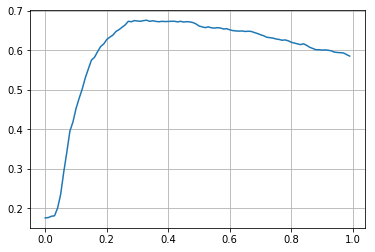

In [30]:
plt.plot(th_list, scores)
plt.grid()

In [31]:
diff_scores3 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["avg_postv12"] = diff_scores3

2782: 0.3614 [0.116]
7843: 0.9750 [0.000]
10534: 0.4833 [-0.186]
11254: 0.7917 [-0.108]
18003: 0.6417 [0.144]
20152: 0.8833 [-0.067]
21767: 0.2583 [0.017]
26709: 0.5500 [0.014]
26746: 0.6833 [-0.011]
28933: 0.5153 [0.053]
31928: 0.9750 [-0.017]
42907: 0.7667 [0.033]
44957: 0.7194 [0.000]
50878: 0.7333 [-0.133]
51010: 0.5083 [0.025]
54955: 0.8083 [-0.067]
57610: 0.8361 [-0.097]


## PostProcess_v2 -> Simple Avg

In [32]:
def post_process_v2(preds, df, c=2, q=0.99, w=1.5):
    if "file_id" not in df.columns:
        df["file_id"] = df["audio_id"].astype(str) + "_" + df["site"]

    post_weight_dict = {}
    init_weight = np.ones(len(const.BIRD_CODE) - 1)

    for i, file_id in enumerate(df["file_id"].unique()):
        file_id_idx = df[df["file_id"] == file_id].index.values
        sum_ = np.sum(preds[file_id_idx, :], axis=0)
        sum_ = sum_ / np.max(sum_)
        quantile_ = np.quantile(sum_, q)
        
        
        post_weight = init_weight.copy()
        for bc in np.argsort(sum_)[::-1]:
            v = sum_[bc]
            if v >= (quantile_ * c):
                post_weight[bc] = w
            else:
                break
                
        post_weight_dict[file_id] = post_weight
        
    post_preds = preds.copy()
    for idx in df.index:
        file_id = df.loc[idx, "file_id"]
        post_weight = post_weight_dict[file_id]
        post_preds[idx, :] = preds[idx, :] * post_weight
    
    return post_preds

In [33]:
c=2.0
q=0.99
w=2.0

post_oof_list = []
for oof_ in oof_list:
    post_oof = post_process_v2(oof_, valid_df, c, q, w)
    post_oof_list.append(post_oof[np.newaxis, :, :])
post_concat_oof = np.concatenate(post_oof_list)

oof = np.mean(post_concat_oof, axis=0)[use_idx, :]

In [34]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [35]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best_score: 0.7038 (th=0.49)

best score: 0.7070 (th=0.31)


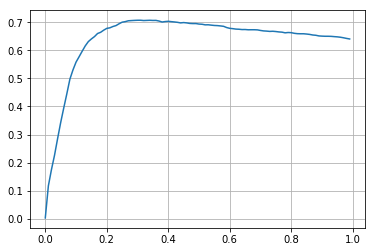

In [36]:
plt.plot(th_list, scores)
plt.grid()

In [37]:
best_labels2 = best_final_labels
diff_scores4 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_avg"] = diff_scores4

2782: 0.4053 [0.160]
7843: 0.9750 [0.000]
10534: 0.7000 [0.031]
11254: 0.8917 [-0.008]
18003: 0.6306 [0.133]
20152: 0.8583 [-0.092]
21767: 0.2750 [0.033]
26709: 0.5361 [0.000]
26746: 0.6944 [0.000]
28933: 0.5164 [0.054]
31928: 0.9667 [-0.025]
42907: 0.7417 [0.008]
44957: 0.7528 [0.033]
50878: 0.8250 [-0.042]
51010: 0.4889 [0.006]
54955: 0.8833 [0.008]
57610: 0.8778 [-0.056]


## PostProcess_v3 -> Simple Avg

In [38]:
def post_process_v3(preds, df):
    if "file_id" not in df.columns:
        df["file_id"] = df["audio_id"].astype(str) + "_" + df["site"]
    
    modified_preds = np.zeros_like(preds)
    for i, file_id in enumerate(df["file_id"].unique()):
        file_id_idx = df[df["file_id"] == file_id].index.values
        mean_ = np.mean(preds[file_id_idx, :], axis=0)
        
        if mean_.std() >= 5e-3:
            weight = (mean_ - mean_.mean()) / mean_.std()
            modified_preds[file_id_idx, :] = preds[file_id_idx, :] * weight
        else:
            modified_preds[file_id_idx, :] = preds[file_id_idx, :]
    
    return modified_preds

In [39]:
post_oof_list = []
for oof_ in oof_list:
    post_oof = post_process_v3(oof_, valid_df)
    post_oof_list.append(post_oof[np.newaxis, :, :])
post_concat_oof = np.concatenate(post_oof_list)

oof = np.mean(post_concat_oof, axis=0)[use_idx, :]

In [40]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(300):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [41]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.6807 (th=2.56)

best score: 0.6877 (th=2.3)


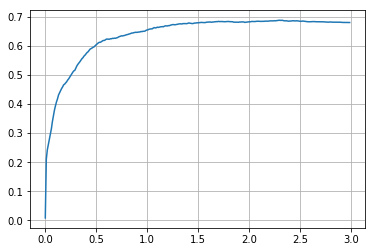

In [42]:
plt.plot(th_list, scores)
plt.grid()

In [43]:
diff_scores5 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["std_avg"] = diff_scores5

2782: 0.3900 [0.145]
7843: 0.9667 [-0.008]
10534: 0.6944 [0.025]
11254: 0.8667 [-0.033]
18003: 0.7028 [0.206]
20152: 0.9167 [-0.033]
21767: 0.2139 [-0.028]
26709: 0.5167 [-0.019]
26746: 0.6861 [-0.008]
28933: 0.4764 [0.014]
31928: 1.0000 [0.008]
42907: 0.6250 [-0.108]
44957: 0.7583 [0.039]
50878: 0.9000 [0.033]
51010: 0.2333 [-0.250]
54955: 0.8333 [-0.042]
57610: 0.9111 [-0.022]


## PostProcess v4 -> Simple Avg
それぞれの鳥の最短距離が近いほど値が大きくなるweightを作成して、oof * weightを計算

In [44]:
def post_process_v4(preds, df):
    site_names = list(const.POS_DICT.keys())
    
    distance_array = np.load("../data/processed/valid_distance_array_from_min_position.npy")
    weight_array1 = np.where(distance_array <= 1, 2, 0)
    weight_array2 = np.where(distance_array <= 3, 1, 0)
    weight_array3 = np.where(distance_array <= 5, 0.5, 0)
    weight_array = weight_array1 + weight_array2 + weight_array3
    
    post_preds = np.zeros_like(preds)
    for idx in df.index:
        site = df.loc[idx, "site"]
        site_idx = site_names.index(site)
        
        post_preds[idx, :] = preds[idx, :] * weight_array[site_idx, :]
    
    return post_preds

In [45]:
post_oof_list = []
for oof_ in oof_list:
    post_oof = post_process_v4(oof_, valid_df)
    post_oof_list.append(post_oof[np.newaxis, :, :])
post_concat_oof = np.concatenate(post_oof_list)

oof = np.mean(post_concat_oof, axis=0)[use_idx, :]

In [46]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(200):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [47]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best_score: 0.6879 (th=0.8)

best score: 0.6856 (th=0.48)


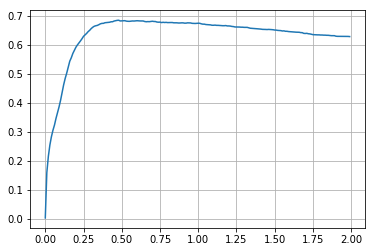

In [48]:
plt.plot(th_list, scores)
plt.grid()

In [49]:
diff_scores6 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["distance_avg"] = diff_scores6

2782: 0.4644 [0.219]
7843: 0.9833 [0.008]
10534: 0.6833 [0.014]
11254: 0.8194 [-0.081]
18003: 0.6611 [0.164]
20152: 0.9500 [0.000]
21767: 0.3125 [0.071]
26709: 0.5361 [0.000]
26746: 0.6917 [-0.003]
28933: 0.5442 [0.082]
31928: 0.9250 [-0.067]
42907: 0.6250 [-0.108]
44957: 0.7083 [-0.011]
50878: 0.9083 [0.042]
51010: 0.2333 [-0.250]
54955: 0.8333 [-0.042]
57610: 0.7750 [-0.158]


## PostProcess v4 -> Simple Avg + nocall classification
それぞれの鳥の最短距離が近いほど値が大きくなるweightを作成して、oof * weightを計算

In [50]:
def post_process_v4(preds, df):
    site_names = list(const.POS_DICT.keys())
    
    distance_array = np.load("../data/processed/valid_distance_array_from_min_position.npy")
    weight_array1 = np.where(distance_array <= 1, 2, 0)
    weight_array2 = np.where(distance_array <= 3, 1, 0)
    weight_array3 = np.where(distance_array <= 5, 0.5, 0)
    weight_array = weight_array1 + weight_array2 + weight_array3
    
    post_preds = np.zeros_like(preds)
    for idx in df.index:
        site = df.loc[idx, "site"]
        site_idx = site_names.index(site)
        
        post_preds[idx, :] = preds[idx, :] * weight_array[site_idx, :]
    
    return post_preds

In [51]:
post_oof_list = []
for oof_ in oof_list:
    post_oof = post_process_v4(oof_, valid_df)
    post_oof_list.append(post_oof[np.newaxis, :, :])
post_concat_oof = np.concatenate(post_oof_list)

oof = np.mean(post_concat_oof, axis=0)[use_idx, :]

In [52]:
for idx in range(len(oof)):
    nocall_p = 1 - oof99[idx]
    if nocall_p <= 0.05:
        col_idx = np.argsort(oof[idx, :])[-1:]
        oof[idx, col_idx] *= 3

In [53]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(300):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [54]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best_score: 0.6902 (th=1.61)

best score: 0.6877 (th=1.41)


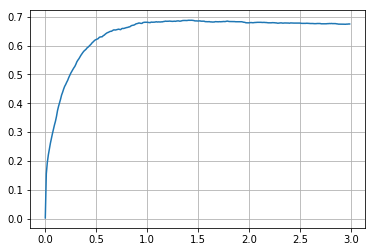

In [55]:
plt.plot(th_list, scores)
plt.grid()

In [56]:
diff_scores7 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["distance_avg_nc"] = diff_scores7

2782: 0.4544 [0.209]
7843: 0.9750 [0.000]
10534: 0.6944 [0.025]
11254: 0.8139 [-0.086]
18003: 0.6528 [0.156]
20152: 0.9750 [0.025]
21767: 0.3153 [0.074]
26709: 0.5611 [0.025]
26746: 0.6861 [-0.008]
28933: 0.5347 [0.072]
31928: 0.9417 [-0.050]
42907: 0.6250 [-0.108]
44957: 0.7111 [-0.008]
50878: 0.9083 [0.042]
51010: 0.2333 [-0.250]
54955: 0.8333 [-0.042]
57610: 0.7750 [-0.158]


## PostProcess v2 + v4 -> Simple Avg

In [57]:
c=1.0
q=0.99
w=1.0

post_oof_list= []
for oof_ in oof_list:
    post_oof_ = post_process_v4(oof_, valid_df)
    post_oof_ = post_process_v2(post_oof_, valid_df, c, q, w)
    post_oof_list.append(post_oof_[np.newaxis, :, :])

post_concat_oof = np.concatenate(post_oof_list, axis=0)
oof = np.mean(post_concat_oof, axis=0)[use_idx, :]

In [58]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(200):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [59]:
print(f"best score: {best_score:.4f} (th={best_th})")   #  best_score: 0.6879 (th=0.8)

best score: 0.6856 (th=0.48)


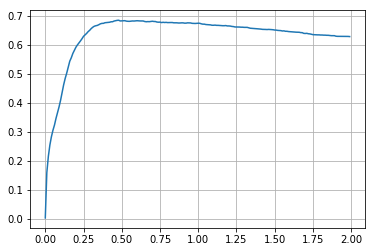

In [60]:
plt.plot(th_list, scores)
plt.grid()

In [61]:
diff_scores8 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["distance_cqw_avg"] = diff_scores8

2782: 0.4644 [0.219]
7843: 0.9833 [0.008]
10534: 0.6833 [0.014]
11254: 0.8194 [-0.081]
18003: 0.6611 [0.164]
20152: 0.9500 [0.000]
21767: 0.3125 [0.071]
26709: 0.5361 [0.000]
26746: 0.6917 [-0.003]
28933: 0.5442 [0.082]
31928: 0.9250 [-0.067]
42907: 0.6250 [-0.108]
44957: 0.7083 [-0.011]
50878: 0.9083 [0.042]
51010: 0.2333 [-0.250]
54955: 0.8333 [-0.042]
57610: 0.7750 [-0.158]


## 前後のlabelがfist_labelと一致していたら...

In [62]:
def intersect(df, col1, col2):
    intersect_list = []
    for idx in df.index.values:
        col1_array = df.loc[idx, col1].split(" ")
        col2_array = df.loc[idx, col2].split(" ")
        intersect = np.intersect1d(col1_array, col2_array)
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def shift(df, freq):
    shift_array = np.array([None] * len(df))

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_array = audio_df["pred_labels"].shift(freq).values
        
        if freq > 0:
            audio_shift_array[:freq] = "None"
        elif freq < 0:
            audio_shift_array[freq:] = "None"
            
        shift_array[idxs] = audio_shift_array

    return shift_array


def arrange_label(label_array):
    arranged_label_array = label_array.copy()
    for idx, label in enumerate(label_array):
        label_list = label.split(" ")
        if "nocall" in label_list and len(label_list) >= 2:
            label_list.remove("nocall")
        
        arranged_label_array[idx] = " ".join(set(label_list))
        
    return arranged_label_array
    

def post_process_v5(preds, pred_labels, df, window_size=1):
    df_  = df.copy()
    
    df_["pred_labels"] = pred_labels
    df_["first_label"] = [const.INV_BIRD_CODE[bc] for bc in np.argsort(preds)[:, -1]]
    
    for i in range(window_size):
        df_[f"pre_pred_labels{i}"] = shift(df_, freq=(i + 1))
        df_[f"post_pred_labels{i}"] = shift(df_, freq=-(i + 1))
    
        df_[f"pre_intersect{i}"] = intersect(df_, "first_label", f"pre_pred_labels{i}")
        df_[f"post_intersect{i}"] = intersect(df_, "first_label", f"post_pred_labels{i}")
    
    concat_labels = df_["pred_labels"]
    for col in df_.columns:
        if "pre_intersect" in col or "post_intersect" in col:
            concat_labels += df_[col].apply(lambda x: f" {x}" if len(x) > 0 else "")
            
    df_["concat_labels"] = concat_labels
    
    post_labels = arrange_label(df_["concat_labels"])
    
    return post_labels

In [63]:
valid_df2 = valid_df.copy()

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [64]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_labels = post_process_v5(oof, oof_labels, valid_df2, window_size=2)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [65]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7218 (th=0.26)

best score: 0.7115 (th=0.3)


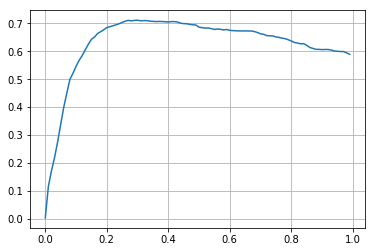

In [66]:
plt.plot(th_list, scores)
plt.grid()

In [67]:
diff_scores9 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["firstlabel_replace"] = diff_scores9

2782: 0.3558 [0.111]
7843: 0.9833 [0.008]
10534: 0.6667 [-0.003]
11254: 0.8583 [-0.042]
18003: 0.6444 [0.147]
20152: 0.8833 [-0.067]
21767: 0.2944 [0.053]
26709: 0.5500 [0.014]
26746: 0.7028 [0.008]
28933: 0.5181 [0.056]
31928: 0.9917 [0.000]
42907: 0.8083 [0.075]
44957: 0.7278 [0.008]
50878: 0.7917 [-0.075]
51010: 0.5528 [0.069]
54955: 0.8750 [0.000]
57610: 0.8917 [-0.042]


## PostProcessV6

- oof_labels = "nocall" & birdcall_p >= 0.99だったら、first_labelを採用

In [68]:
def post_process_v6(preds, pred_labels, birdcall_preds, df):
    first_label = [const.INV_BIRD_CODE[bc] for bc in np.argsort(preds, axis=1)[:, -1]]

    processed_pred_labels = []
    for idx, labels in enumerate(pred_labels):
        if labels == "nocall" and birdcall_preds[idx] >= 0.99 and np.max(preds[idx, :]) >= 0.1:
            processed_pred_labels.append(first_label[idx])
        else:
            processed_pred_labels.append(labels)
    
    return processed_pred_labels

In [69]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [70]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_labels = post_process_v6(oof, oof_labels, oof99, valid_df)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [71]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.6610 (th=0.36)

best score: 0.6645 (th=0.31)


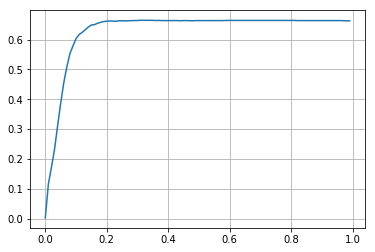

In [72]:
plt.plot(th_list, scores)
plt.grid()

In [73]:
diff_scores10 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["nocall_birdcall_replace"] = diff_scores10

2782: 0.2533 [0.008]
7843: 0.9750 [0.000]
10534: 0.6583 [-0.011]
11254: 0.8917 [-0.008]
18003: 0.5139 [0.017]
20152: 0.9500 [0.000]
21767: 0.2583 [0.017]
26709: 0.5361 [0.000]
26746: 0.7028 [0.008]
28933: 0.4625 [0.000]
31928: 0.9917 [0.000]
42907: 0.7417 [0.008]
44957: 0.7194 [0.000]
50878: 0.8500 [-0.017]
51010: 0.4889 [0.006]
54955: 0.8833 [0.008]
57610: 0.9333 [0.000]


## PostProcessV7

- audio_id全体のbirdcall_predsの平均値が0.5以上だったら、PostProcessV5

In [74]:
def intersect(df, col1, col2):
    intersect_list = []
    for idx in df.index.values:
        col1_array = df.loc[idx, col1].split(" ")
        col2_array = df.loc[idx, col2].split(" ")
        intersect = np.intersect1d(col1_array, col2_array)
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def shift(df, freq):
    shift_array = np.array([None] * len(df))

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_array = audio_df["pred_labels"].shift(freq).values
        
        if freq > 0:
            audio_shift_array[:freq] = "None"
        elif freq < 0:
            audio_shift_array[freq:] = "None"
            
        shift_array[idxs] = audio_shift_array

    return shift_array


def arrange_label(label_array):
    arranged_label_array = label_array.copy()
    for idx, label in enumerate(label_array):
        label_list = label.split(" ")
        if "nocall" in label_list and len(label_list) >= 2:
            label_list.remove("nocall")
        
        arranged_label_array[idx] = " ".join(set(label_list))
        
    return arranged_label_array
    

def post_process_v7(preds, pred_labels, birdcall_preds, df, window_size=1):
    df_  = df.copy()
    
    df_["pred_labels"] = pred_labels
    df_["first_label"] = [const.INV_BIRD_CODE[bc] for bc in np.argsort(preds)[:, -1]]
    df_["birdcall_preds"] = birdcall_preds
    df_["sum_birdcall_preds"] = df_.groupby("audio_id")["birdcall_preds"].transform("mean")
    
    for i in range(window_size):
        df_[f"pre_pred_labels{i}"] = shift(df_, freq=(i + 1))
        df_[f"post_pred_labels{i}"] = shift(df_, freq=-(i + 1))
    
        df_[f"pre_intersect{i}"] = intersect(df_, "first_label", f"pre_pred_labels{i}")
        df_[f"post_intersect{i}"] = intersect(df_, "first_label", f"post_pred_labels{i}")
    
    concat_labels = df_["pred_labels"]
    for col in df_.columns:
        if "pre_intersect" in col or "post_intersect" in col:
            concat_labels += df_[col].apply(lambda x: f" {x}" if len(x) > 0 else "")
            
    df_["concat_labels"] = arrange_label(concat_labels)
    
    post_pred_labels = []
    for idx in df_.index:
        audio_birdcall_preds = df_.loc[idx, "sum_birdcall_preds"]
        if audio_birdcall_preds >= 0.5:
            post_label = df_.loc[idx, "concat_labels"]
        else:
            post_label = df_.loc[idx, "pred_labels"]
            
        post_pred_labels.append(post_label)
    
    return post_pred_labels

In [75]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [76]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_labels = post_process_v7(oof, oof_labels, oof99, valid_df, window_size=2)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [77]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7243 (th=0.26)

best score: 0.7143 (th=0.3)


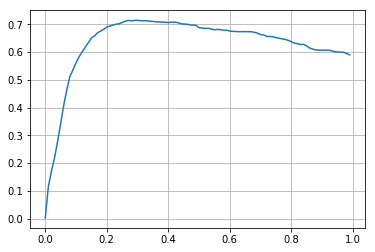

In [78]:
plt.plot(th_list, scores)
plt.grid()

In [79]:
diff_scores11 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["birdcall_preds0.5_and_v5"] = diff_scores11

2782: 0.2664 [0.021]
7843: 0.9750 [0.000]
10534: 0.6667 [-0.003]
11254: 0.8917 [-0.008]
18003: 0.5139 [0.017]
20152: 0.9500 [0.000]
21767: 0.2667 [0.025]
26709: 0.5361 [0.000]
26746: 0.7028 [0.008]
28933: 0.4667 [0.004]
31928: 0.9917 [0.000]
42907: 0.7417 [0.008]
44957: 0.7194 [0.000]
50878: 0.8417 [-0.025]
51010: 0.4972 [0.014]
54955: 0.8667 [-0.008]
57610: 0.9333 [0.000]


## PostProcessV8

- PostProcessV5の修正版

In [80]:
def shift(df, pred_labels, freq):
    shift_labels = [None] * len(df)

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_labels = np.roll(pred_labels[idxs[0]: idxs[-1] + 1], freq)
        
        if freq > 0:
            audio_shift_labels[:freq] = "None"
        elif freq < 0:
            audio_shift_labels[freq:] = "None"
            
        shift_labels[idxs[0]: idxs[-1] + 1] = audio_shift_labels

    return shift_labels


def intersect(labels_list1, labels_list2):
    intersect_list = []
    for idx in range(len(labels_list1)):
        lables1 = labels_list1[idx].split(" ")
        lables2 = labels_list2[idx].split(" ")
        
        intersect = np.intersect1d(lables1, lables2)
        if len(intersect) == 0:
            intersect = ["nocall"]
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def add_label(labels_list1, labels_list2):
    added_labels_list = []
    for labels1, labels2 in zip(labels_list1, labels_list2):

        if labels1 == "nocall":
            if labels2 == "nocall":
                added_labels_list.append("nocall")
            else:
                added_labels_list.append(labels2)
        
        else:
            if labels2 == "nocall":
                added_labels_list.append(labels1)
            else:
                added_labels = list(set((labels1 + " " + labels2).split(" ")))
                added_labels_list.append(" ".join(added_labels))
    
    return added_labels_list


def post_process_v8(preds, pred_labels, df, window_size=1):
    confident_labels = [const.INV_BIRD_CODE[bc] for bc in np.argsort(preds)[:, -1]]

    final_labels_list = pred_labels.copy()
    for w in range(window_size):
        for freq in [w + 1, -(w + 1)]:
            shift_labels = shift(df, pred_labels, freq)
            shift_intersect_labels = intersect(confident_labels, shift_labels)
            final_labels_list = add_label(final_labels_list, shift_intersect_labels)
        
    return final_labels_list

In [81]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [82]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_labels = post_process_v8(oof, oof_labels, valid_df, window_size=3)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [83]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7224 (th=0.27)

best score: 0.7120 (th=0.42)


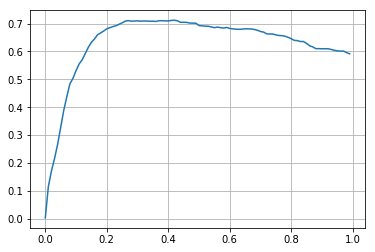

In [84]:
plt.plot(th_list, scores)
plt.grid()

In [85]:
best_labels8 = best_final_labels
diff_scores12 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["modified_firstlabel_replace"] = diff_scores12

2782: 0.3372 [0.092]
7843: 0.9833 [0.008]
10534: 0.6861 [0.017]
11254: 0.8833 [-0.017]
18003: 0.6444 [0.147]
20152: 0.9167 [-0.033]
21767: 0.2750 [0.033]
26709: 0.5444 [0.008]
26746: 0.7028 [0.008]
28933: 0.4861 [0.024]
31928: 0.9917 [0.000]
42907: 0.8167 [0.083]
44957: 0.7194 [0.000]
50878: 0.7917 [-0.075]
51010: 0.5444 [0.061]
54955: 0.8833 [0.008]
57610: 0.8972 [-0.036]


In [86]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall     156
rucwar      63
obnthr1      7
grasal1      4
wbwwre1      3
rubwre1      3
bucmot2      2
sthwoo1      1
yebfly       1
Name: preds, dtype: int64

## Avg -> V2 -> V8

In [87]:
def post_process_v2_plus(preds, df, c=2, q=0.99, w=1.5):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        audio_preds = preds[idxs, :]
        audio_preds_mean = np.mean(audio_preds, axis=0)
        audio_preds_mean_ = audio_preds_mean / audio_preds_mean.max()
        quantile = np.quantile(audio_preds_mean_, q)

        for bc in np.argsort(audio_preds_mean_)[::-1]:
            v = audio_preds_mean_[bc]
            if v >= (quantile * c):
                for idx in idxs:
                    if np.argmax(post_preds[idx, :]) == bc:
                        post_preds[idx, bc] *= w
            else:
                break

    return post_preds

In [88]:
c=2.0
q=0.99
w=2.0

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v2_plus(oof, valid_df, c, q, w)

In [89]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(300)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    post_labels = post_process_v8(post_oof, oof_labels, valid_df, window_size=2)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [90]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7294 (th=0.55)

best score: 0.7200 (th=0.59)


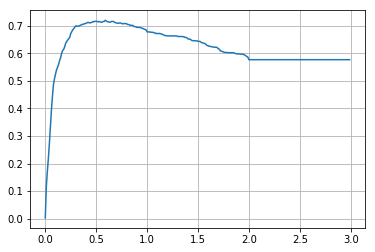

In [91]:
plt.plot(th_list, scores)
plt.grid()

In [92]:
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.3531 [0.108]
7843: 0.9833 [0.008]
10534: 0.6528 [-0.017]
11254: 0.8500 [-0.050]
18003: 0.6694 [0.172]
20152: 0.9250 [-0.025]
21767: 0.2944 [0.053]
26709: 0.5444 [0.008]
26746: 0.7028 [0.008]
28933: 0.5125 [0.050]
31928: 1.0000 [0.008]
42907: 0.8000 [0.067]
44957: 0.7611 [0.042]
50878: 0.9417 [0.075]
51010: 0.4778 [-0.006]
54955: 0.8333 [-0.042]
57610: 0.9389 [0.006]


In [93]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall     166
rucwar      63
grasal1      4
wbwwre1      3
rubwre1      3
sthwoo1      1
Name: preds, dtype: int64

## PostProcessV9
- https://www.kaggle.com/cdeotte/rainforest-post-process-lb-0-970
- 全然うまくいかない......というかよく分かっていない

In [94]:
def scale(probs, factor):
    probs = probs.copy()
    idx = np.where(probs!=1)[0]
    odds = factor * probs[idx] / (1 - probs[idx])
    probs[idx] =  odds / (1 + odds)
    return probs


def post_process_v9(preds):
    post_preds = preds.copy()

    post_preds -= post_preds.min(0, keepdims=True)
    post_preds /= post_preds.max(0, keepdims=True)
    d2 = np.mean(post_preds, axis=0)

    for k in range(397):
        s = (d2[k] / (1 - d2[k])) / 2.0
        post_preds[:, k] = scale(post_preds[:, k], s)

    return post_preds

In [95]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v9(oof)

In [96]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [97]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7506 (th=0.27)

best score: 0.5267 (th=0.28)


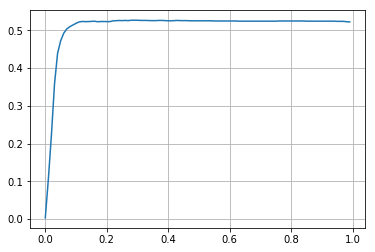

In [98]:
plt.plot(th_list, scores)
plt.grid()

In [99]:
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.0139 [-0.231]
7843: 0.9500 [-0.025]
10534: 0.4083 [-0.261]
11254: 0.7333 [-0.167]
18003: 0.1306 [-0.367]
20152: 0.9250 [-0.025]
21767: 0.1750 [-0.067]
26709: 0.4667 [-0.069]
26746: 0.5083 [-0.186]
28933: 0.1625 [-0.300]
31928: 0.9417 [-0.050]
42907: 0.5222 [-0.211]
44957: 0.4917 [-0.228]
50878: 0.8000 [-0.067]
51010: 0.2194 [-0.264]
54955: 0.7917 [-0.083]
57610: 0.7139 [-0.219]


## PostProcessV10
- PPv8の修正版？

In [100]:
def shift(df, pred_labels, freq):
    shift_labels = [None] * len(df)

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_labels = np.roll(pred_labels[idxs[0]: idxs[-1] + 1], freq)
        
        if freq > 0:
            audio_shift_labels[:freq] = "None"
        elif freq < 0:
            audio_shift_labels[freq:] = "None"
            
        shift_labels[idxs[0]: idxs[-1] + 1] = audio_shift_labels

    return shift_labels


def intersect(labels_list1, labels_list2):
    intersect_list = []
    for idx in range(len(labels_list1)):
        lables1 = labels_list1[idx].split(" ")
        lables2 = labels_list2[idx].split(" ")
        
        intersect = np.intersect1d(lables1, lables2)
        if len(intersect) == 0:
            intersect = ["nocall"]
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def add_label(labels_list1, labels_list2):
    added_labels_list = []
    for labels1, labels2 in zip(labels_list1, labels_list2):

        if labels1 == "nocall":
            if labels2 == "nocall":
                added_labels_list.append("nocall")
            else:
                added_labels_list.append(labels2)
        
        else:
            if labels2 == "nocall":
                added_labels_list.append(labels1)
            else:
                added_labels = list(set((labels1 + " " + labels2).split(" ")))
                added_labels_list.append(" ".join(added_labels))
    
    return added_labels_list


def post_process_v10(preds, pred_labels, df, window_size=1, c=2.0):
    first_labels = []
    for idx in df.index:
        row_prob = preds[idx, :]
        second_prob = np.sort(row_prob)[-2]

        first_label_bc = np.argmax(row_prob)
        v = row_prob[first_label_bc]
        if v >= (second_prob * c):
            first_labels.append(const.INV_BIRD_CODE[first_label_bc])
        else:
            first_labels.append("nocall")

    final_labels_list = pred_labels.copy()
    for w in range(window_size):
        for freq in [w + 1, -(w + 1)]:
            shift_labels = shift(df, pred_labels, freq)
            shift_intersect_labels = intersect(first_labels, shift_labels)
            final_labels_list = add_label(final_labels_list, shift_intersect_labels)
        
    return final_labels_list

In [101]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [102]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_oof_labels = post_process_v10(oof, oof_labels, valid_df, window_size=2, c=2)
    score = row_wise_micro_averaged_f1_score(val_y_labels, post_oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_oof_labels

    th_list.append(th)
    scores.append(score)

In [103]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7140 (th=0.29)

best score: 0.7071 (th=0.3)


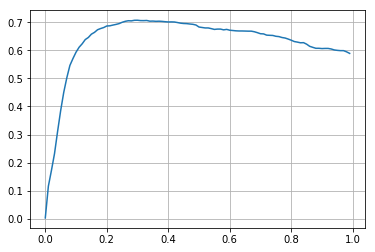

In [104]:
plt.plot(th_list, scores)
plt.grid()

In [105]:
best_labels10 = best_final_labels
diff_scores14 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores14

2782: 0.3308 [0.086]
7843: 0.9833 [0.008]
10534: 0.6667 [-0.003]
11254: 0.8667 [-0.033]
18003: 0.6194 [0.122]
20152: 0.8917 [-0.058]
21767: 0.2806 [0.039]
26709: 0.5583 [0.022]
26746: 0.6944 [0.000]
28933: 0.5181 [0.056]
31928: 0.9917 [0.000]
42907: 0.7667 [0.033]
44957: 0.7444 [0.025]
50878: 0.8250 [-0.042]
51010: 0.5250 [0.042]
54955: 0.8583 [-0.017]
57610: 0.9000 [-0.033]


## Avg -> V2 -> V10

In [195]:
oof_list = [
    oof112,
    oof114,
    oof115,
    oof116,
    oof117,
    oof118,

    oof129,
    oof131,
    oof132,
    oof139,
    oof159,
#     oof160,
    oof161,
]

concat_oof = []
for oof_ in oof_list:
    concat_oof.append(oof_[np.newaxis, :, :])
concat_oof = np.concatenate(concat_oof)

In [196]:
def post_process_v2_plus(preds, df, c=2, q=0.99, w=1.5):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        audio_preds = preds[idxs, :]
        audio_preds_mean = np.mean(audio_preds, axis=0)
        audio_preds_mean_ = audio_preds_mean / audio_preds_mean.max()
        quantile = np.quantile(audio_preds_mean_, q)

        for bc in np.argsort(audio_preds_mean_)[::-1]:
            v = audio_preds_mean_[bc]
            if v >= (quantile * c):
                for idx in idxs:
                    if np.argmax(post_preds[idx, :]) == bc:
                        post_preds[idx, bc] *= w
            else:
                break

    return post_preds

In [197]:
c=2.5
q=0.99
w=2.0

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v2_plus(oof, valid_df, c, q, w)

In [198]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(30, 80)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    post_labels = post_process_v10(post_oof, oof_labels, valid_df, window_size=5, c=2.0)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [199]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7472 (th=0.65)

best score: 0.7494 (th=0.61)


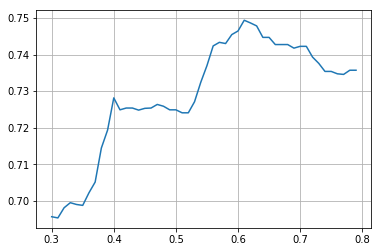

In [200]:
plt.plot(th_list, scores)
plt.grid()

In [201]:
best_labels_2_10 = best_final_labels
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.4494 [0.204]
7843: 0.9667 [-0.008]
10534: 0.6583 [-0.011]
11254: 0.8833 [-0.017]
18003: 0.7583 [0.261]
20152: 0.9750 [0.025]
21767: 0.3861 [0.144]
26709: 0.5444 [0.008]
26746: 0.7028 [0.008]
28933: 0.5181 [0.056]
31928: 1.0000 [0.008]
42907: 0.8417 [0.108]
44957: 0.8250 [0.106]
50878: 0.9333 [0.067]
51010: 0.5333 [0.050]
54955: 0.8333 [-0.042]
57610: 0.9306 [-0.003]


In [202]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall     145
rucwar      76
obnthr1      6
wbwwre1      5
rubwre1      3
grasal1      3
sthwoo1      1
yebfly       1
Name: preds, dtype: int64

## Avg -> V2 -> nc -> V10

In [113]:
c=2.5
q=0.99
w=2.0

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v2_plus(oof, valid_df, c, q, w)

In [114]:
birdcall_p = oof99

for idx in range(len(post_oof)):
    bp = birdcall_p[idx]
    if bp <= 0.1:
        col1_idx = np.argsort(post_oof[idx, :])[-1:]
        post_oof[idx, col1_idx] /= 2

In [115]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(30, 80)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    post_labels = post_process_v10(post_oof, oof_labels, valid_df, window_size=5, c=2.0)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [116]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7472 (th=0.65)

best score: 0.7289 (th=0.59)


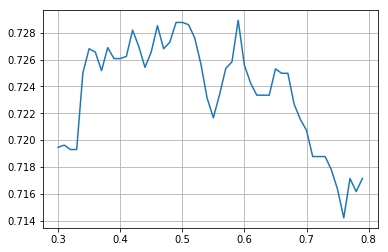

In [117]:
plt.plot(th_list, scores)
plt.grid()

In [118]:
best_labels_2_10 = best_final_labels
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.4003 [0.155]
7843: 0.9833 [0.008]
10534: 0.6917 [0.022]
11254: 0.8417 [-0.058]
18003: 0.6944 [0.197]
20152: 0.9667 [0.017]
21767: 0.3167 [0.075]
26709: 0.5444 [0.008]
26746: 0.7028 [0.008]
28933: 0.5139 [0.051]
31928: 1.0000 [0.008]
42907: 0.8000 [0.067]
44957: 0.7833 [0.064]
50878: 0.9250 [0.058]
51010: 0.4556 [-0.028]
54955: 0.8333 [-0.042]
57610: 0.9389 [0.006]


In [119]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall     160
rucwar      68
wbwwre1      5
rubwre1      3
grasal1      3
sthwoo1      1
Name: preds, dtype: int64

## PostProcessV11

In [120]:
def post_process_v11(preds, birdcall_preds, th=0.3, w=0.5):
    post_preds = preds.copy()
    for idx in range(len(preds)):
        bc_prob = birdcall_preds[idx]
        if bc_prob <= th:
            post_preds[idx, :] = preds[idx, :] * w
    
    return post_preds

In [121]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]
bc_oof = oof99.copy()
post_oof = post_process_v11(oof, bc_oof, th=0.5, w=0.1)

In [122]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [123]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7027 (th=0.26)

best score: 0.6991 (th=0.27)


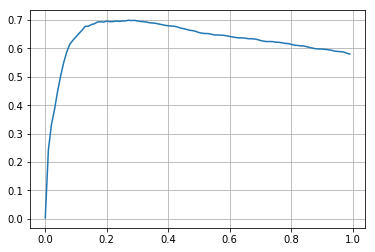

In [124]:
plt.plot(th_list, scores)
plt.grid()

In [125]:
diff_scores1 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["avg_nc"] = diff_scores1

2782: 0.3164 [0.071]
7843: 0.9750 [0.000]
10534: 0.6500 [-0.019]
11254: 0.8917 [-0.008]
18003: 0.5528 [0.056]
20152: 0.9583 [0.008]
21767: 0.2792 [0.038]
26709: 0.5361 [0.000]
26746: 0.7028 [0.008]
28933: 0.4667 [0.004]
31928: 0.9917 [0.000]
42907: 0.7250 [-0.008]
44957: 0.7278 [0.008]
50878: 0.8333 [-0.033]
51010: 0.5028 [0.019]
54955: 0.8750 [0.000]
57610: 0.9000 [-0.033]


## PostProcessV12
- V2_plusの改良版

In [126]:
def post_process_v12(preds, df, window_size=5, c=2, q=0.99, w=1.5):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        for i, idx in enumerate(idxs):
            if i < window_size:
                start = idxs[0]
                end = min(idx + window_size + 1, idxs[-1] + 1)
            else:
                start = idx - window_size
                end = min(idx + window_size + 1, idxs[-1] + 1)

            marginal_preds = preds[start: end, :]
            marginal_preds_mean = np.mean(marginal_preds, axis=0)
            quantile = np.quantile(marginal_preds_mean, q)
            
            for bc in np.argsort(marginal_preds_mean)[::-1]:
                v = marginal_preds_mean[bc]
                if v >= max(0.1, (quantile * c)) and np.argmax(post_preds[idx, :]) == bc:
                    post_preds[idx, bc] *= w
                else:
                    break

    return post_preds

In [127]:
window_size = 10
c=2.0
q=0.99
w=2.0

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v12(oof, valid_df, window_size, c, q, w)

In [128]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [129]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7027 (th=0.26)

best score: 0.7068 (th=0.34)


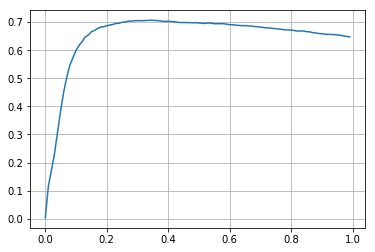

In [130]:
plt.plot(th_list, scores)
plt.grid()

## Avg -> V12 -> V10

In [131]:
window_size = 50
c = 2.5
q=0.99
w=1.5

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v12(oof, valid_df, window_size, c, q, w)

In [132]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    post_labels = post_process_v10(post_oof, oof_labels, valid_df, window_size=5, c=2.0)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [133]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7472 (th=0.65)

best score: 0.7186 (th=0.37)


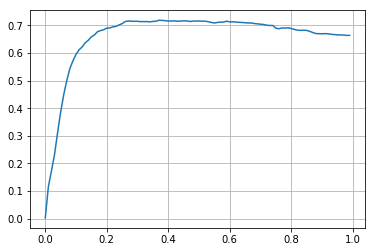

In [134]:
plt.plot(th_list, scores)
plt.grid()

In [135]:
best_labels_2_10 = best_final_labels
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.3864 [0.141]
7843: 0.9833 [0.008]
10534: 0.6778 [0.008]
11254: 0.8750 [-0.025]
18003: 0.6778 [0.181]
20152: 0.9167 [-0.033]
21767: 0.2722 [0.031]
26709: 0.5444 [0.008]
26746: 0.6944 [0.000]
28933: 0.5236 [0.061]
31928: 0.9917 [0.000]
42907: 0.8000 [0.067]
44957: 0.7667 [0.047]
50878: 0.8417 [-0.025]
51010: 0.5083 [0.025]
54955: 0.8667 [-0.008]
57610: 0.8889 [-0.044]


In [136]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall     151
rucwar      67
obnthr1      7
wbwwre1      5
rubwre1      3
grasal1      3
bucmot2      2
sthwoo1      1
yebfly       1
Name: preds, dtype: int64

## PostProcess V13
- V2の改良版

In [137]:
def post_process_v13(preds, df, c=2, q=0.99, w1=1.5, w2=1.5):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        audio_preds = preds[idxs, :]
        audio_preds_mean = np.mean(audio_preds, axis=0)
        audio_preds_mean_ = audio_preds_mean / audio_preds_mean.max()
        quantile = np.quantile(audio_preds_mean_, q)
        prior_flg = False

        for bc in np.argsort(audio_preds_mean_)[::-1]:
            v = audio_preds_mean_[bc]
            if v >= (quantile * c):
                for idx in idxs:
                    if np.argmax(post_preds[idx, :]) == bc:
                        post_preds[idx, bc] *= w1
                        if prior_flg:
                            post_preds[idx, bc] *= w2
                        prior_flg = True
                    else:
                        prior_flg = False
            else:
                break

    return post_preds

In [138]:
c=2.5
q=0.99
w1=2.0
w2=1.2

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v13(oof, valid_df, c, q, w1, w2)

In [139]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(30, 100)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    post_labels = post_process_v8(post_oof, oof_labels, valid_df, window_size=2)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [140]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7294 (th=0.55)

best score: 0.7212 (th=0.59)


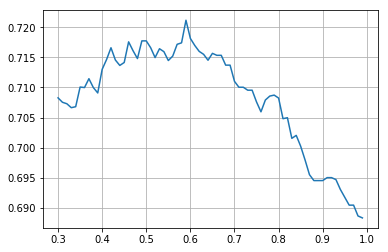

In [141]:
plt.plot(th_list, scores)
plt.grid()

In [142]:
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.3697 [0.125]
7843: 0.9833 [0.008]
10534: 0.6444 [-0.025]
11254: 0.8500 [-0.050]
18003: 0.6694 [0.172]
20152: 0.9667 [0.017]
21767: 0.2944 [0.053]
26709: 0.5444 [0.008]
26746: 0.7028 [0.008]
28933: 0.4958 [0.033]
31928: 1.0000 [0.008]
42907: 0.8000 [0.067]
44957: 0.7611 [0.042]
50878: 0.9417 [0.075]
51010: 0.4639 [-0.019]
54955: 0.8333 [-0.042]
57610: 0.9389 [0.006]


In [143]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall     166
rucwar      63
grasal1      4
wbwwre1      3
rubwre1      3
sthwoo1      1
Name: preds, dtype: int64

## Avg -> V13 -> V10

In [144]:
c=2.5
q=0.99
w1=2.0
w2=1.3

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v13(oof, valid_df, c, q, w1, w2)

In [145]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(30, 80)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    post_labels = post_process_v10(post_oof, oof_labels, valid_df, window_size=5, c=1.5)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [146]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7517 (th=0.65)

best score: 0.7331 (th=0.59)


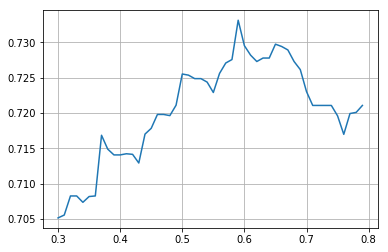

In [147]:
plt.plot(th_list, scores)
plt.grid()

In [148]:
best_labels_2_10 = best_final_labels
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.4350 [0.190]
7843: 0.9833 [0.008]
10534: 0.6917 [0.022]
11254: 0.8417 [-0.058]
18003: 0.7028 [0.206]
20152: 0.9667 [0.017]
21767: 0.3167 [0.075]
26709: 0.5444 [0.008]
26746: 0.7028 [0.008]
28933: 0.5222 [0.060]
31928: 1.0000 [0.008]
42907: 0.7917 [0.058]
44957: 0.7833 [0.064]
50878: 0.9167 [0.050]
51010: 0.4917 [0.008]
54955: 0.8333 [-0.042]
57610: 0.9389 [0.006]


In [149]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall     159
rucwar      69
wbwwre1      5
rubwre1      3
grasal1      3
sthwoo1      1
Name: preds, dtype: int64

## Avg -> V13_plus -> V10

In [150]:
def post_process_v13_plus(preds, df, c=2, q=0.99, w1=1.5, ws=1.5):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        audio_preds = preds[idxs, :]
        audio_preds_mean = np.mean(audio_preds, axis=0)
        audio_preds_mean_ = audio_preds_mean / audio_preds_mean.max()
        quantile = np.quantile(audio_preds_mean_, q)
        counter = 0

        for bc in np.argsort(audio_preds_mean_)[::-1]:
            v = audio_preds_mean_[bc]
            if v >= (quantile * c):
                for idx in idxs:
                    if np.argmax(post_preds[idx, :]) == bc:
                        post_preds[idx, bc] *= w1
                        if counter > 0:
                            post_preds[idx, bc] *= (w2 ** counter)
                        counter += 1
                    else:
                        counter = 0
            else:
                break

    return post_preds

In [151]:
c=2.5
q=0.99
w1=2.0
w2=1.05

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v13_plus(oof, valid_df, c, q, w1, w2)

In [152]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(30, 80)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    post_labels = post_process_v10(post_oof, oof_labels, valid_df, window_size=5, c=1.5)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [153]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7472 (th=0.65)

best score: 0.7308 (th=0.59)


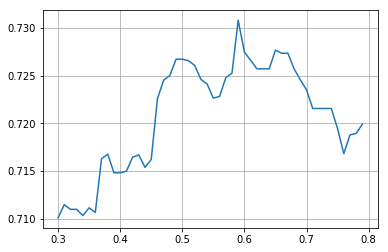

In [154]:
plt.plot(th_list, scores)
plt.grid()

In [155]:
best_labels_2_10 = best_final_labels
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.4003 [0.155]
7843: 0.9833 [0.008]
10534: 0.6917 [0.022]
11254: 0.8417 [-0.058]
18003: 0.7028 [0.206]
20152: 0.9667 [0.017]
21767: 0.3167 [0.075]
26709: 0.5444 [0.008]
26746: 0.7028 [0.008]
28933: 0.5181 [0.056]
31928: 1.0000 [0.008]
42907: 0.7917 [0.058]
44957: 0.7833 [0.064]
50878: 0.9167 [0.050]
51010: 0.4917 [0.008]
54955: 0.8333 [-0.042]
57610: 0.9389 [0.006]


In [156]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall     159
rucwar      69
wbwwre1      5
rubwre1      3
grasal1      3
sthwoo1      1
Name: preds, dtype: int64

## SED

In [157]:
clip_framewise_outputs_dict = joblib.load("./clip_framewise_outputs_dict.pkl")
clip_clipwise_outputs_dict = joblib.load("./clip_clipwise_outputs_dict.pkl")

In [158]:
unit = 3001

a = np.where(clip_framewise_outputs_dict["7843"] >= 0.95, 1, 0)
clip_list = []

for i in range(20):
    b = a[unit * i: unit * (i + 1), :]
    c = np.where(b.sum(0) >= 1, 1, 0).sum()
    clip_list.append(c)
    
clip_list

[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

## Final Voting
- Simple Avg
- Nocall Classification
- V2
- V8
- V10
- Avg > V2 > V10

In [159]:
post_labels_list = [
    best_labels1,
    best_labels_nc,
    best_labels2,
    best_labels8,
    best_labels_2_10,
]

for vote_lim in range(len(post_labels_list)):
    final_oof_labels = voting(post_labels_list, vote_lim=vote_lim)
    score = row_wise_micro_averaged_f1_score(val_y_labels, final_oof_labels)
    print(f"vote_lim={vote_lim}   {score:.4f}")

vote_lim=0   0.7170
vote_lim=1   0.7170
vote_lim=2   0.7255
vote_lim=3   0.7086
vote_lim=4   0.7001


In [160]:
a = pd.DataFrame(post_labels_list).T
a.columns = [f"post{i}" for i in range(len(post_labels_list))]
a["final"] = final_oof_labels
a

,post0,post1,post2,post3,post4,final
0,wbwwre1,wbwwre1,wbwwre1,wbwwre1,wbwwre1,wbwwre1
1,wbwwre1,wbwwre1,wbwwre1,wbwwre1,wbwwre1,wbwwre1
2,wbwwre1,wbwwre1,wbwwre1,wbwwre1,wbwwre1,wbwwre1
3,nocall,nocall,nocall,nocall,nocall,nocall
4,rubwre1,rubwre1,rubwre1,rubwre1,rubwre1,rubwre1
...,...,...,...,...,...,...
2035,nocall,nocall,nocall,nocall,nocall,nocall
2036,nocall,nocall,nocall,nocall,nocall,nocall
2037,grycat,nocall,grycat,nocall,nocall,nocall
2038,grycat,nocall,nocall,nocall,nocall,nocall


## 閾値研究

In [161]:
def optim_th(y_labels, preds):
    best_score = 0
    besth_th = 0
    best_final_labels = None
    base_score = 0

    for i in range(100):
        th = i / 100.0

        pred_labels = extract_label(preds, th)

        score = row_wise_micro_averaged_f1_score(y_labels, pred_labels)

        if best_score < score:
            best_score  = score
            best_th = th
            best_final_labels = pred_labels
            
        if th == 0.33:
            base_score = score
        
    return best_score, best_th, base_score


def get_info(df):
    site = df["site"].values[0]
    nocall_num = len(df[df["birds"] == "nocall"])
    birdcall_num = len(df[df["birds"] != "nocall"])
    return site, nocall_num, birdcall_num


def get_preds_info(preds):
    mean_row_mean = preds.mean(axis=0).mean()
    mean_row_max = preds.max(axis=0).mean()
    return mean_row_mean, mean_row_max

def get_pred_labels_info(pred_labels):
    pred_nocall_count = 0
    for labels in pred_labels:
        if labels == "nocall":
            pred_nocall_count += 1
    
    return pred_nocall_count

In [162]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]
oof_labels = extract_label(oof, th=0.26)

In [163]:
th_dict = {}

gp = valid_df.groupby("audio_id")
for audio_id, audio_df in gp:
    idx = audio_df.index.values
    score, th, base_score = optim_th(audio_df["birds"].values, oof[idx, :])
    site, nocall_num, birdcall_num = get_info(audio_df)
    mean_row_mean, mean_row_max = get_preds_info(oof[idx, :])
    birdcall_p = oof99[idx, :].mean()
    pred_nocall_count = get_pred_labels_info(oof_labels[idx[0]: idx[-1] + 1])

    th_dict[audio_id] = {
        "site": site,
        "best_th": th,
        "score": score,
        "change_score": score - base_score,
        "nocall_num": nocall_num,
        "birdcall_num": birdcall_num,
        "mean_row_mean": mean_row_mean,
        "mean_row_max": mean_row_max,
        "birdcall_p": birdcall_p,
        "pred_nocall_count": pred_nocall_count,
    }

In [164]:
score_df = pd.DataFrame.from_dict(th_dict, orient="index")
score_df.sort_values(by="best_th")

,site,best_th,score,change_score,nocall_num,birdcall_num,mean_row_mean,mean_row_max,birdcall_p,pred_nocall_count
21767,COR,0.06,0.315000,0.073333,22,98,0.001689,0.031201,0.999986,90
2782,SSW,0.07,0.531389,0.286389,0,120,0.002126,0.019707,0.993905,63
28933,SSW,0.08,0.553056,0.090556,18,102,0.002131,0.025237,0.956717,66
18003,COR,0.13,0.652778,0.155556,24,96,0.001851,0.024733,0.993982,65
7843,SSW,0.14,0.983333,0.008333,116,4,0.002432,0.009063,0.639814,119
42907,SSW,0.15,0.744444,0.011111,75,45,0.002052,0.020365,0.725713,101
26709,SSW,0.19,0.552778,0.016667,62,58,0.001990,0.016315,0.690525,115
51010,SSW,0.25,0.511111,0.027778,28,92,0.002125,0.033224,0.984260,73
26746,COR,0.27,0.702778,0.008333,71,49,0.001908,0.022899,0.999573,103
44957,COR,0.29,0.736111,0.016667,49,71,0.002156,0.028263,0.994803,68


In [165]:
(score_df["score"].values * 120).sum() / 2040

0.7429411764705879

In [166]:
diff_df = pd.DataFrame.from_dict(all_diff_scores)
columns = list(diff_df.columns)

diff_df = pd.concat([
    valid_df[valid_df["birds"] == "nocall"].groupby("audio_id").size(),
    valid_df.groupby("audio_id")["site"].unique(),
    pd.DataFrame.from_dict(score_dict, orient="index", columns=["score"]),
    diff_df,
], axis=1)

diff_df.columns = ["nocall_num", "site", "score"] + columns

diff_df["nocall_num"] = diff_df["nocall_num"].fillna(0)
diff_df["site"] = diff_df["site"].apply(lambda x: x[0])

diff_df.sort_values(by="nocall_num")

,nocall_num,site,score,avg,avg_nc,voting,avg_postv12,cqw_avg,std_avg,distance_avg,distance_avg_nc,distance_cqw_avg,firstlabel_replace,nocall_birdcall_replace,birdcall_preds0.5_and_v5,modified_firstlabel_replace,cqw_and_modified_firstlabel_replace
2782,0.0,SSW,0.245000,0.071389,0.071389,0.082500,0.116389,0.160278,0.145000,0.219444,0.209444,0.219444,0.110833,0.008333,0.021389,9.222222e-02,0.155278
28933,18.0,SSW,0.462500,0.004167,0.004167,0.004167,0.052778,0.053889,0.013889,0.081667,0.072222,0.081667,0.055556,0.000000,0.004167,2.361111e-02,0.055556
21767,22.0,COR,0.241667,0.037500,0.037500,0.026389,0.016667,0.033333,-0.027778,0.070833,0.073611,0.070833,0.052778,0.016667,0.025000,3.333333e-02,0.075000
18003,24.0,COR,0.497222,0.055556,0.055556,0.038889,0.144444,0.133333,0.205556,0.163889,0.155556,0.163889,0.147222,0.016667,0.016667,1.472222e-01,0.205556
51010,28.0,SSW,0.483333,0.019444,0.019444,0.006944,0.025000,0.005556,-0.250000,-0.250000,-0.250000,-0.250000,0.069444,0.005556,0.013889,6.111111e-02,0.008333
44957,49.0,COR,0.719444,0.008333,0.008333,-0.002778,0.000000,0.033333,0.038889,-0.011111,-0.008333,-0.011111,0.008333,0.000000,0.000000,1.110223e-16,0.063889
26709,62.0,SSW,0.536111,0.000000,0.000000,0.008333,0.013889,0.000000,-0.019444,0.000000,0.025000,0.000000,0.013889,0.000000,0.000000,8.333333e-03,0.008333
10534,63.0,SSW,0.669444,-0.019444,-0.019444,-0.011111,-0.186111,0.030556,0.025000,0.013889,0.025000,0.013889,-0.002778,-0.011111,-0.002778,1.666667e-02,0.022222
26746,71.0,COR,0.694444,0.008333,0.008333,-0.011111,-0.011111,0.000000,-0.008333,-0.002778,-0.008333,-0.002778,0.008333,0.008333,0.008333,8.333333e-03,0.008333
42907,75.0,SSW,0.733333,-0.008333,-0.008333,0.025000,0.033333,0.008333,-0.108333,-0.108333,-0.108333,-0.108333,0.075000,0.008333,0.008333,8.333333e-02,0.058333


In [167]:
diff_df[diff_df["nocall_num"] >= 100]

,nocall_num,site,score,avg,avg_nc,voting,avg_postv12,cqw_avg,std_avg,distance_avg,distance_avg_nc,distance_cqw_avg,firstlabel_replace,nocall_birdcall_replace,birdcall_preds0.5_and_v5,modified_firstlabel_replace,cqw_and_modified_firstlabel_replace
7843,116.0,SSW,0.975000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008333,0.008333,0.000000,0.008333,0.008333,0.000000,0.000000,0.008333,0.008333
11254,105.0,COR,0.900000,-0.008333,-0.008333,-0.019444,-0.108333,-0.008333,-0.033333,-0.080556,-0.086111,-0.080556,-0.041667,-0.008333,-0.008333,-0.016667,-0.058333
20152,116.0,SSW,0.950000,0.000000,0.008333,-0.008333,-0.066667,-0.091667,-0.033333,0.000000,0.025000,0.000000,-0.066667,0.000000,0.000000,-0.033333,0.016667
31928,120.0,COR,0.991667,0.000000,0.000000,0.000000,-0.016667,-0.025000,0.008333,-0.066667,-0.050000,-0.066667,0.000000,0.000000,0.000000,0.000000,0.008333
50878,115.0,COR,0.866667,-0.033333,-0.033333,-0.066667,-0.133333,-0.041667,0.033333,0.041667,0.041667,0.041667,-0.075000,-0.016667,-0.025000,-0.075000,0.050000
54955,100.0,SSW,0.875000,-0.008333,0.000000,-0.008333,-0.066667,0.008333,-0.041667,-0.041667,-0.041667,-0.041667,0.000000,0.008333,-0.008333,0.008333,-0.041667


In [168]:
diff_df[diff_df["site"] == "SSW"].sort_values(by="nocall_num")

,nocall_num,site,score,avg,avg_nc,voting,avg_postv12,cqw_avg,std_avg,distance_avg,distance_avg_nc,distance_cqw_avg,firstlabel_replace,nocall_birdcall_replace,birdcall_preds0.5_and_v5,modified_firstlabel_replace,cqw_and_modified_firstlabel_replace
2782,0.0,SSW,0.245000,0.071389,0.071389,0.082500,0.116389,0.160278,0.145000,0.219444,0.209444,0.219444,0.110833,0.008333,0.021389,0.092222,0.155278
28933,18.0,SSW,0.462500,0.004167,0.004167,0.004167,0.052778,0.053889,0.013889,0.081667,0.072222,0.081667,0.055556,0.000000,0.004167,0.023611,0.055556
51010,28.0,SSW,0.483333,0.019444,0.019444,0.006944,0.025000,0.005556,-0.250000,-0.250000,-0.250000,-0.250000,0.069444,0.005556,0.013889,0.061111,0.008333
26709,62.0,SSW,0.536111,0.000000,0.000000,0.008333,0.013889,0.000000,-0.019444,0.000000,0.025000,0.000000,0.013889,0.000000,0.000000,0.008333,0.008333
10534,63.0,SSW,0.669444,-0.019444,-0.019444,-0.011111,-0.186111,0.030556,0.025000,0.013889,0.025000,0.013889,-0.002778,-0.011111,-0.002778,0.016667,0.022222
42907,75.0,SSW,0.733333,-0.008333,-0.008333,0.025000,0.033333,0.008333,-0.108333,-0.108333,-0.108333,-0.108333,0.075000,0.008333,0.008333,0.083333,0.058333
54955,100.0,SSW,0.875000,-0.008333,0.000000,-0.008333,-0.066667,0.008333,-0.041667,-0.041667,-0.041667,-0.041667,0.000000,0.008333,-0.008333,0.008333,-0.041667
7843,116.0,SSW,0.975000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008333,0.008333,0.000000,0.008333,0.008333,0.000000,0.000000,0.008333,0.008333
20152,116.0,SSW,0.950000,0.000000,0.008333,-0.008333,-0.066667,-0.091667,-0.033333,0.000000,0.025000,0.000000,-0.066667,0.000000,0.000000,-0.033333,0.016667


In [169]:
diff_df[diff_df["site"] == "COR"].sort_values(by="nocall_num")

,nocall_num,site,score,avg,avg_nc,voting,avg_postv12,cqw_avg,std_avg,distance_avg,distance_avg_nc,distance_cqw_avg,firstlabel_replace,nocall_birdcall_replace,birdcall_preds0.5_and_v5,modified_firstlabel_replace,cqw_and_modified_firstlabel_replace
21767,22.0,COR,0.241667,0.037500,0.037500,0.026389,0.016667,0.033333,-0.027778,0.070833,0.073611,0.070833,0.052778,0.016667,0.025000,3.333333e-02,0.075000
18003,24.0,COR,0.497222,0.055556,0.055556,0.038889,0.144444,0.133333,0.205556,0.163889,0.155556,0.163889,0.147222,0.016667,0.016667,1.472222e-01,0.205556
44957,49.0,COR,0.719444,0.008333,0.008333,-0.002778,0.000000,0.033333,0.038889,-0.011111,-0.008333,-0.011111,0.008333,0.000000,0.000000,1.110223e-16,0.063889
26746,71.0,COR,0.694444,0.008333,0.008333,-0.011111,-0.011111,0.000000,-0.008333,-0.002778,-0.008333,-0.002778,0.008333,0.008333,0.008333,8.333333e-03,0.008333
57610,93.0,COR,0.933333,-0.033333,-0.033333,-0.030556,-0.097222,-0.055556,-0.022222,-0.158333,-0.158333,-0.158333,-0.041667,0.000000,0.000000,-3.611111e-02,0.005556
11254,105.0,COR,0.900000,-0.008333,-0.008333,-0.019444,-0.108333,-0.008333,-0.033333,-0.080556,-0.086111,-0.080556,-0.041667,-0.008333,-0.008333,-1.666667e-02,-0.058333
50878,115.0,COR,0.866667,-0.033333,-0.033333,-0.066667,-0.133333,-0.041667,0.033333,0.041667,0.041667,0.041667,-0.075000,-0.016667,-0.025000,-7.500000e-02,0.050000
31928,120.0,COR,0.991667,0.000000,0.000000,0.000000,-0.016667,-0.025000,0.008333,-0.066667,-0.050000,-0.066667,0.000000,0.000000,0.000000,0.000000e+00,0.008333
